## xsapr_clutter

Determining in radar volumes when wind farms are appearing
as clutter. The clutter is then flagged, 1 = clutter,
0 = no clutter.

In [2]:
import glob
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pyart
import scipy
import gc
from matplotlib import animation
from IPython.display import Image
get_ipython().magic(
    'install_ext https://raw.github.com/cpcloud/ipython-\
autotime/master/autotime.py')
get_ipython().magic('load_ext autotime')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR:root:Line magic function `%install_ext` not found.
/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 08:53:22.188795. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
import gc
import numpy as np
import pyart


def xsapr_clutter(files, out_file, clutter_threshold=0.0002,
                  radius=1):
    """
    X-SAPR Wind Farm Clutter Calculation
    
    Parameters
    ----------
    files : list
        List of radar files used for X-SAPR clutter calculation.
    out_file : string
        File path and name for where new radar object will be
        written to.

    Other Parameters
    ----------------
    clutter_threshold : float
        Threshold value for which, values obtained from
        the radars reflectivity standard deviations divided by the
        means, if any of these values are below the threshold,
        they will be considered clutter.
    radius : int
        Radius of the area surrounding the clutter gate that will
        be also flagged as clutter.

    Returns
    -------
    clutter_radar : Radar
        Radar object with the clutter field that was calculated.
        This radar only has the clutter field, but maintains all
        other radar specifications.

    """

    run_stats = RunningStats()
    for file in files:
        radar = pyart.io.read(file)
        if radar.fields[
            'reflectivity']['data'].shape == (9200, 501):
            reflect_array = (radar.fields['reflectivity']['data'])
        else:
            print(str(file), ' skipped',
                radar.fields['reflectivity']['data'].shape)
        del radar
        gc.collect()
        run_stats.push(reflect_array)
    mean = run_stats.mean()
    stdev = run_stats.standard_deviation()
    #new_means = expit(mean / 1000)
    clutter_values = stdev / mean
    clutter_array = _clutter_calculation(clutter_values,
                                         clutter_threshold,
                                         radius)
    clutter_radar = pyart.io.read(files[0])
    clutter_radar.fields.clear()
    clutter_dict = _clutter_to_dict(clutter_array)
    clutter_radar.add_field('xsapr_clutter', clutter_dict,
                            replace_existing=True)
    pyart.io.write_cfradial(out_file, clutter_radar)
    return clutter_radar


def _clutter_calculation(clutter_values, clutter_threshold,
                         radius):
    """ Takes clutter_values(stdev/mean)and the clutter_threshold
    and calculates where X-SAPR wind farm clutter is occurring at
    the SGP ARM site. """
    is_clutters = np.argwhere(clutter_values > clutter_threshold)
    shape = clutter_values.shape
    mask = np.ma.getmask(clutter_values)
    temp_array = np.zeros(shape)
    temp_array = np.pad(temp_array, radius,
                        mode='constant', constant_values=-999)
    is_clutters = is_clutters + radius
    x_val, y_val = np.ogrid[-radius:(radius + 1),
                            -radius:(radius + 1)]
    circle = (x_val * x_val) + (y_val * y_val) <= (radius * radius)
    for is_clutter in is_clutters:
        ray, gate = is_clutter[0], is_clutter[1]
        frame = temp_array[ray - radius:ray + radius + 1,
                           gate - radius:gate + radius + 1]
        temp_array[ray - radius:ray + radius + 1,
                   gate - radius:gate + radius + 1] = np.logical_or(
            frame, circle)
    temp_array = temp_array[radius:shape[0] + radius,
                            radius:shape[1] + radius]
    clutter_array = np.ma.array(temp_array, mask=mask)
    return clutter_array


def _clutter_to_dict(clutter_array):
    """ Function that takes the clutter array
    and turn it into a dictionary to be used and added
    to the pyart radar object. """
    clutter_dict = {}
    clutter_dict['units'] = 'unitless'
    clutter_dict['data'] = clutter_array
    clutter_dict['standard_name'] = 'xsapr_clutter'
    clutter_dict['long_name'] = 'X-SAPR Clutter'
    clutter_dict['notes'] = '0: No Clutter, 1: Clutter'
    return clutter_dict


class RunningStats:
    """ Calculated Mean, Variance and Standard Deviation, but
    uses the Welford algorithm to save memory. """
    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return np.sqrt(self.variance())

time: 119 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 08:53:46.595490. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [5]:
files = sorted(glob.glob('/home/zsherman/xsapr_clutter_project/data/*'))

time: 1.94 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 08:53:47.388245. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
#8.1069902e-31
clutter_radar = xsapr_clutter(
    files, '/home/zsherman/clutter_radar.nc', 0.00002)

time: 1min 29s


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 08:53:48.668074. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [42]:
files = files[0:25]
run_stats = RunningStats()
for file in files:
    radar = pyart.io.read(file)
    if radar.fields[
        'reflectivity']['data'].shape == (9200, 501):
        reflect_array = (radar.fields['reflectivity']['data'])
    else:
        print(str(file), ' skipped',
            radar.fields['reflectivity']['data'].shape)
    del radar
    gc.collect()
    run_stats.push(reflect_array)
mean = run_stats.mean()
stdev = run_stats.standard_deviation()
clutter_values = stdev / mean
is_clutters = np.argwhere(clutter_values < 0.00002)

time: 15.8 s


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:02:47.759824. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [43]:
is_clutters

array([[   0,    0],
       [   0,    1],
       [   0,    3],
       ..., 
       [9199,  498],
       [9199,  499],
       [9199,  500]])

time: 2.16 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:03:03.600358. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [44]:
np.where(is_clutters)

(array([      1,       2,       3, ..., 4536185, 4536186, 4536186]),
 array([1, 1, 1, ..., 1, 0, 1]))

time: 199 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:03:03.606110. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [45]:
is_clutters = np.argwhere(clutter_values > 0.00002)

time: 23 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:03:03.809452. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [46]:
is_clutters[1].shape

(2,)

time: 2.34 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:03:03.837268. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [47]:
print(mean.max())
print(mean.min())
print(mean.mean())

53.6772
-53.1468
-12.9946027839
time: 25.2 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:03:03.843565. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [48]:
print(mean[is_clutters].max())
print(mean[is_clutters].min())
print(mean[is_clutters].mean())

53.6772
-53.1468
-10.0082204746
time: 286 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:03:03.871876. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [49]:
reflect_array.min()

-71.589996

time: 5.98 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:03:04.160973. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [51]:
print(clutter_values.min())
print(clutter_values.max())

-3202.02
2650.86
time: 13.9 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:04:05.789279. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [52]:
np.percentile(clutter_values, 3)

-0.36839613586664205

time: 35.2 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:04:10.300420. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [53]:
clutter_values.min()

-3202.0173

time: 7.95 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:04:10.956379. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


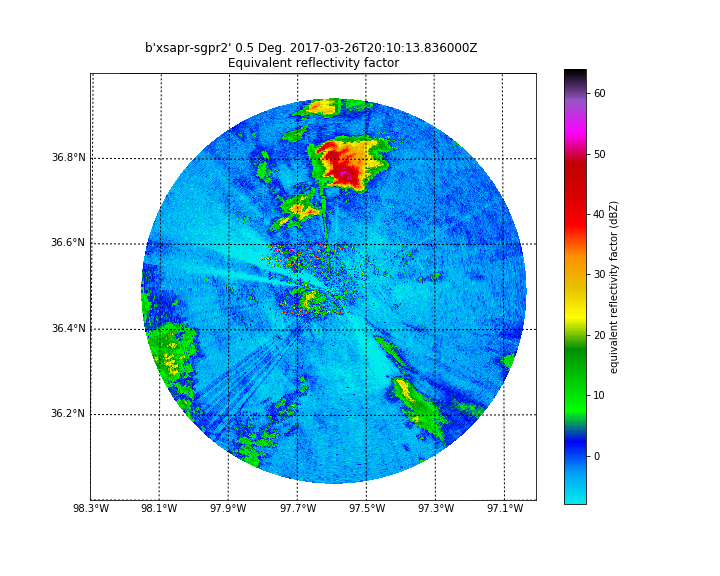

time: 12.7 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:04:13.468434. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [54]:
Image("/home/zsherman/xsapr_clutter_project/images/windfarm_x_wide.png")

/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


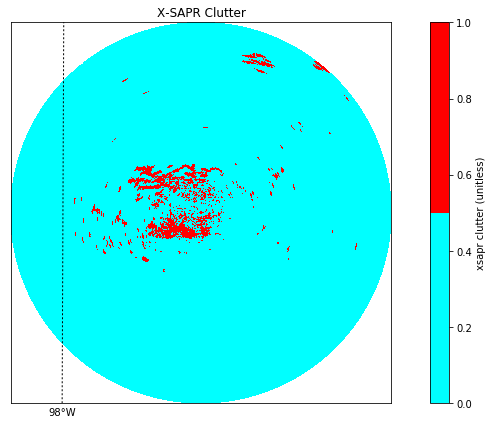

time: 7.85 s


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-05 09:11:48.157794. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [104]:
ticks = ([0.25, 0.75])
ticklabs = (['No Clutter', 'Clutter'])
title = 'X-SAPR Clutter'
fig = plt.figure(figsize=(14, 7))
my_display = pyart.graph.RadarMapDisplay(clutter_radar)
lab_colors=['cyan', 'red']
cmap = matplotlib.colors.ListedColormap(lab_colors)
my_display.plot_ppi_map('xsapr_clutter', sweep=0,
                        cmap=cmap, title=title)


plt.savefig('/home/zsherman/xsapr_clutter_project/images/xsapr_clutter_surround_gates.png', bbox_inches='tight')
plt.show()

In [8]:
radar = pyart.io.read(files[0])
reflect = radar.fields['reflectivity']['data']

time: 465 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 09:14:44.662810. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


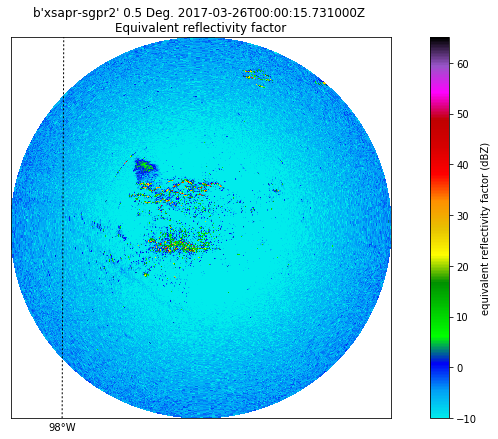

time: 7.88 s


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 09:15:00.263660. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:
fig = plt.figure(figsize=(14, 7))
my_display = pyart.graph.RadarMapDisplay(radar)
my_display.plot_ppi_map('reflectivity', sweep=0, vmin=-10, vmax=65)

plt.show()

In [13]:
radars = []
for i in range(len(clutter_radar.sweep_number['data'])):
    sweep_number = clutter_radar.sweep_number['data'][i]
    one_sweep = clutter_radar.extract_sweeps([sweep_number])
    radars += [one_sweep]

lab_colors=['cyan', 'red']
cmap = matplotlib.colors.ListedColormap(lab_colors)
# Create a plot for each sweep, and have each plot be a frame.
def animate(nframe):
    plt.clf()
    display = pyart.graph.RadarMapDisplay(radars[nframe])
    display.plot_ppi_map('xsapr_clutter', sweep=0,
                         cmap=cmap)

fig = plt.figure(figsize=(10, 8))
anim = animation.FuncAnimation(fig, animate, frames=len(radars))
anim.save('/home/zsherman/xsapr_clutter_project/images/xsapr_clutter_animation.gif',
          writer='imagemagick', fps=1)
plt.close()

/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


time: 3min 6s


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 09:15:47.368609. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


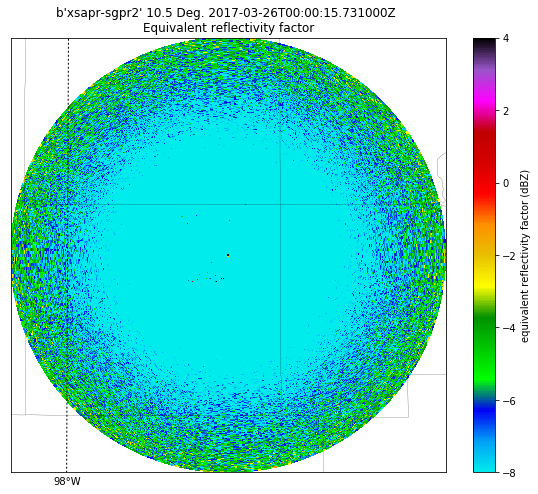

time: 2.98 s


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 09:14:45.558917. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
fig = plt.figure(figsize=(10, 8))
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity', sweep=10, resolution='l',
                     vmin=-8, vmax=4, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     lat_lines=None, lon_lines=None)
display.basemap.drawcounties()

plt.show()

In [130]:
reflect_radars = []
for i in range(len(radar.sweep_number['data'])):
    sweep_number = radar.sweep_number['data'][i]
    one_sweep = radar.extract_sweeps([sweep_number])
    reflect_radars += [one_sweep]

# Create a plot for each sweep, and have each plot be a frame.
def animate(nframe):
    plt.clf()
    display = pyart.graph.RadarMapDisplay(reflect_radars[nframe])
    display.plot_ppi_map('reflectivity', resolution='l',
                         vmin=-8, vmax=64, mask_outside=False,
                         cmap=pyart.graph.cm.NWSRef,
                         lat_lines=None, lon_lines=None)
    display.basemap.drawcounties()

fig = plt.figure(figsize=(10, 8))
anim = animation.FuncAnimation(fig, animate,
                               frames=len(reflect_radars))
anim.save('/home/zsherman/xsapr_clutter_project/images/reflectivity_animation.gif',
          writer='imagemagick', fps=1)

/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/zsherman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


time: 1min 7s


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-05 09:27:41.776762. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [131]:
def animate(nframe):
    plt.clf()
    radar = pyart.io.read(files[nframe])
    display = pyart.graph.RadarDisplay(radar)
    del radar
    display.plot('reflectivity', sweep=0,
                 vmin=-10, vmax=65, cmap='pyart_NWSRef')

fig = plt.figure(figsize=(10,8))
anim = animation.FuncAnimation(fig, animate, frames=len(files))
anim.save('/home/zsherman/xsapr_clutter_project/images/all_xsapr_files_sweep_0.gif', writer='imagemagick', fps=3)

time: 2min 12s


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-05 09:28:49.202386. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [14]:
clutter_radar.fields

{'xsapr_clutter': {'data': masked_array(data =
   [[0.0 1.0 1.0 ..., 0.0 0.0 0.0]
   [0.0 1.0 1.0 ..., 0.0 0.0 0.0]
   [0.0 1.0 1.0 ..., 0.0 0.0 0.0]
   ..., 
   [0.0 1.0 1.0 ..., -- 0.0 0.0]
   [0.0 1.0 1.0 ..., -- -- --]
   [0.0 1.0 1.0 ..., 0.0 -- 0.0]],
               mask =
   [[False False False ..., False False False]
   [False False False ..., False False False]
   [False False False ..., False False False]
   ..., 
   [False False False ...,  True False False]
   [False False False ...,  True  True  True]
   [False False False ..., False  True False]],
         fill_value = 1e+20),
  'long_name': 'X-SAPR Clutter',
  'notes': '0: No Clutter, 1: Clutter',
  'standard_name': 'xsapr_clutter',
  'units': 'unitless'}}

time: 7.05 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:19.969976. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
a = np.array([1, np.nan, 3, 4, 5, 6, 7])
b = np.array([8, 9, 10, 11, 12, 13, 14])
c = np.array([15, 16, 17, 18, 19, 20, 21])

d = np.array([21, 14, 19, 5, 6, np.nan, 15])
e = np.array([14, 8, 12, 17, 19, 32, 21])
f = np.array([1, 2, 3, 4, 5, 6, 7])

g = np.array([37, 25, 19, 3.5, 6, 23, 15])
h = np.array([14, 8, 12, 17, 19, 32, 21])
i = np.array([7, 9, 12, 23, 27, 45, 1])

time: 6.41 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:20.332441. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
blah1 = []
blah1.append(a)
blah1.append(b)
blah1.append(c)

blah2 = []
blah2.append(d)
blah2.append(e)
blah2.append(f)

blah3 = []
blah3.append(g)
blah3.append(h)
blah3.append(i)

time: 4.01 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:21.196884. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
arr_one = np.stack(blah1)
arr_two = np.stack(blah2)
arr_three = np.stack(blah3)

time: 3.55 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:21.581971. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
print(arr_one.shape)
print(arr_one)
print(arr_two.shape)
print(arr_two)
print(arr_three.shape)
print(arr_three)

(3, 7)
[[  1.  nan   3.   4.   5.   6.   7.]
 [  8.   9.  10.  11.  12.  13.  14.]
 [ 15.  16.  17.  18.  19.  20.  21.]]
(3, 7)
[[ 21.  14.  19.   5.   6.  nan  15.]
 [ 14.   8.  12.  17.  19.  32.  21.]
 [  1.   2.   3.   4.   5.   6.   7.]]
(3, 7)
[[ 37.   25.   19.    3.5   6.   23.   15. ]
 [ 14.    8.   12.   17.   19.   32.   21. ]
 [  7.    9.   12.   23.   27.   45.    1. ]]
time: 6.71 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:21.982101. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
boths = np.stack((arr_one, arr_two, arr_three))

time: 2.15 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:22.301820. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:
boths = np.ma.masked_invalid(boths)

time: 2.25 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:22.653826. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [21]:
shape = boths[0].shape
my = np.zeros(shape)
my

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

time: 3.1 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:22.971855. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [22]:
std = np.std(boths, axis=0)
std

masked_array(data =
 [[14.72714802291635 5.5 7.542472332656507 0.6236095644623235
  0.4714045207910317 8.5 3.7712361663282534]
 [2.8284271247461903 0.4714045207910317 0.9428090415820634
  2.8284271247461903 3.299831645537222 8.9566858950296 3.299831645537222]
 [5.734883511361751 5.715476066494082 5.792715732327589 8.04155872120988
  9.092121131323903 16.131404843417148 8.379870059984357]],
             mask =
 [[False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]],
       fill_value = 1e+20)

time: 3.58 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:23.420819. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
mean = np.mean(boths, axis=0)
mean

masked_array(data =
 [[19.666666666666668 19.5 13.666666666666666 4.166666666666667
  5.666666666666667 14.5 12.333333333333334]
 [12.0 8.333333333333334 11.333333333333334 15.0 16.666666666666668
  25.666666666666668 18.666666666666668]
 [7.666666666666667 9.0 10.666666666666666 15.0 17.0 23.666666666666668
  9.666666666666666]],
             mask =
 [[False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]],
       fill_value = 1e+20)

time: 12.1 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:23.790412. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:
clutter_vals = std/mean
clutter_vals

masked_array(data =
 [[0.7488380350635432 0.28205128205128205 0.5518882194626713
  0.14966629547095764 0.08318903308077029 0.5862068965517241
  0.3057759053779665]
 [0.23570226039551587 0.056568542494923796 0.08318903308077029
  0.1885618083164127 0.1979898987322333 0.3489617881180364
  0.1767766952966369]
 [0.7480282840906631 0.6350528962771202 0.5430670999057116
  0.5361039147473253 0.534830654783759 0.6816086553556541
  0.8668831096535543]],
             mask =
 [[False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]],
       fill_value = 1e+20)

time: 10.9 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:24.238465. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [25]:
is_clutters = np.where(clutter_vals < 0.1)
is_clutters

(array([0, 1, 1]), array([4, 1, 2]))

time: 2.88 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:24.651754. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
clutter_vals[is_clutters]

masked_array(data = [0.08318903308077029 0.056568542494923796 0.08318903308077029],
             mask = [False False False],
       fill_value = 1e+20)

time: 4.47 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:25.006482. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [29]:
is_clutters = np.argwhere(clutter_vals < 0.1)
print(is_clutters)
for is_clutter in is_clutters:
    one_north = np.array([is_clutter[0] - 1, is_clutter[1]])
    one_south = np.array([is_clutter[0] + 1, is_clutter[1]])
    one_east = np.array([is_clutter[0], is_clutter[1] + 1])
    one_west = np.array([is_clutter[0], is_clutter[1] - 1])
    is_clutters = np.vstack([is_clutters, one_north,
                             one_south, one_east, one_west])
sorted_idx = np.lexsort(is_clutters.T)
sorted_data =  is_clutters[sorted_idx,:]
row_mask = np.append([True], np.any(np.diff(sorted_data,axis=0),1))
outs = sorted_data[row_mask]
outs

[[0 4]
 [1 1]
 [1 2]]


array([[ 1,  0],
       [ 0,  1],
       [ 1,  1],
       [ 2,  1],
       [ 0,  2],
       [ 1,  2],
       [ 2,  2],
       [ 0,  3],
       [ 1,  3],
       [-1,  4],
       [ 0,  4],
       [ 1,  4],
       [ 0,  5]])

time: 14 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:30.373084. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [30]:
print(one_north)
print(one_south)
print(one_east)
print(one_west)

[0 2]
[2 2]
[1 3]
[1 1]
time: 3.32 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:31.083752. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [31]:
blah3 = []
blah3.append(a)
blah3.append(b)
blah3.append(c)
test_arr = np.ma.vstack(blah3)
test_arr = np.ma.masked_invalid(test_arr)

time: 6.81 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:31.534120. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [32]:
print(test_arr)
print(test_arr[0, 3])

[[1.0 -- 3.0 4.0 5.0 6.0 7.0]
 [8.0 9.0 10.0 11.0 12.0 13.0 14.0]
 [15.0 16.0 17.0 18.0 19.0 20.0 21.0]]
4.0
time: 3.75 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:31.949400. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [33]:
for is_clutter in is_clutters:
    test_arr[is_clutter[0], is_clutter[1]] = 99999.
test_arr[test_arr < 99999.] = 0
test_arr[test_arr == 99999.] = 1

time: 1.84 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:32.347652. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [34]:
test_arr

masked_array(data =
 [[0.0 1.0 1.0 1.0 1.0 1.0 0.0]
 [1.0 1.0 1.0 1.0 1.0 0.0 0.0]
 [0.0 1.0 1.0 0.0 1.0 0.0 0.0]],
             mask =
 [[False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]],
       fill_value = 1e+20)

time: 4.74 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:32.701237. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [35]:
class RunningStats:

    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = np.add(self.old_m ,
                                np.divide((np.subtract(x , self.old_m)) ,
                                          self.n))
            self.new_s = np.add(self.old_s ,
            (np.multiply(np.subtract(x , self.old_m) ,
                        np.subtract(x , self.new_m))))

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return np.divide(self.new_s , (np.subtract(self.n , 1))) if self.n > 1 else 0.0

    def standard_deviation(self):
        return np.sqrt(self.variance())

rs = RunningStats()    
for both in boths:
    rs.push(both)

    mean = rs.mean();
    variance = rs.variance();
    stdev = rs.standard_deviation();

time: 31.3 ms


/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:882: RuntimeWarning: invalid value encountered in less
  return umath.less(x, self.critical_value)
/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:33.148009. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [36]:
variance

masked_array(data =
 [[325.33333333333337 -- 85.33333333333334 0.5833333333333335
  0.33333333333333326 -- 21.333333333333332]
 [12.0 0.3333333333333335 1.333333333333333 12.0 16.333333333333332
  120.33333333333333 16.333333333333332]
 [49.333333333333336 49.0 50.333333333333336 97.0 124.0 390.33333333333337
  105.33333333333334]],
             mask =
 [[False  True False False False  True False]
 [False False False False False False False]
 [False False False False False False False]],
       fill_value = 1e+20)

time: 2.64 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:33.740890. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [37]:
mean

masked_array(data =
 [[19.666666666666664 -- 13.666666666666666 4.166666666666667
  5.666666666666667 -- 12.333333333333334]
 [12.0 8.333333333333334 11.333333333333334 15.0 16.666666666666668
  25.666666666666668 18.666666666666668]
 [7.666666666666667 9.0 10.666666666666666 15.0 17.0 23.666666666666664
  9.666666666666668]],
             mask =
 [[False  True False False False  True False]
 [False False False False False False False]
 [False False False False False False False]],
       fill_value = 1e+20)

time: 7.4 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:34.125716. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [38]:
my_arr = np.zeros((12,8))
my_arr[0, 3] = np.nan
my_arr = np.ma.masked_invalid(my_arr)
my_arr

masked_array(data =
 [[0.0 0.0 0.0 -- 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]],
             mask =
 [[False False False  True False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False F

time: 3.75 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:34.412024. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [39]:
my_mask = np.ma.getmask(my_arr)
my_mask
new_arr = np.zeros((12, 8))

time: 3.17 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:34.845963. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [40]:
a, b = 11, 0
n1 = 8
n2 = 12

y, x = np.ogrid[-a:n2-a, -b:n1-b]
clutter = x*x + y*y <= r*r

new_arr[clutter] = 1
mask_arr = np.ma.array(new_arr, mask=my_mask)

NameError: name 'r' is not defined

time: 13.7 ms


/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-09 11:01:35.450138. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
